<a href="https://colab.research.google.com/github/Anukriti2001/Anukriti/blob/master/SmartCoach_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing necessary libraries and modules

In [ ]:
import pandas as pd #for data manipulation and analysis
import numpy as np #for multidimensional arrays
import re #for regular expressions
from numpy import log
import matplotlib.pyplot as plt #for visualization

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
import tensorflow as tf
#from tensorflow.keras.optimizers.legacy import Adam
from collections import deque
import time
import random
from tqdm import tqdm
import os

In [ ]:
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gym
import numpy as np

In [ ]:
!pip install stable-baselines3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


State Space : Heart Rate, Systolic Blood Pressure, Diastolic Blood Pressure, Oxygen levels and Calories Burnt

Additional data input: Gender, Age, Height, Weight

Action Space: Normal treadmill walk(low level), Aerobic treadmill walk(moderate level), High intensity treadmill walk(HIIT level), Treadmill run, Cycling, Rest(Cool down)

Gender = 0 for female and 1 for male

In [ ]:
gender = np.random.randint(0,3)
gender

1

In [ ]:
age = np.random.randint(20,70)
age

33

In [ ]:
weight = np.random.randint(50,108)
weight

87

In [ ]:
height = np.random.randint(150,180)
height

157

In [ ]:
bmi = weight/((height/100) * (height/100))
bmi

35.295549515193315

In [ ]:
if(gender == 0):
  gd = 3
else:
  gd = 4

Defining heart rates for different zones

In [ ]:
#also for 100% intensity(heart rate)
max_hr = 211 - (0.64 * age)
max_hr

189.88

In [ ]:
#heart rate
general_thr_min = 60
general_thr_max = 100
safe_zone_min = 0.6 * max_hr
safe_zone_max = 0.9 * max_hr
walking_thr_min = 0.5 * max_hr
walking_thr_max = 0.85 * max_hr
walking_aerobic_min = 0.7 * max_hr
walking_aerobic_max = 0.8 * max_hr
walking_hiit_min = 0.8 * max_hr
walking_hiit_max = max_hr
running_hiit_min = 0.7 * max_hr
running_hiit_max = 0.85 * max_hr
cycling_min = 0.5 * max_hr
cycling_max = 0.6 * max_hr
weightllifting_min = 0.8 * max_hr
weightllifting_max = 0.95 * max_hr

Defining blood pressure for different zones

In [ ]:
#blood pressure
normal_sys_max = 120
normal_dia_max = 80
normal_sys_min = 90
normal_dia_min = 60
#normal_bp = normal_sys_max & normal_dia_max
elevated_sys_min = 120
elevated_sys_max = 129
elevated_dia_max = 80
#elevated_bp = (elevated_sys_min || elevated_sys_max) & elevated_dia_max
hyper1_sys_min = 130
hyper1_sys_max = 139
hyper1_dia_min = 80
hyper1_dia_max = 89
#hyper1_bp = (hyper1_sys_min || hyper1_sys_max) | (hyper1_dia_min || hyper1_dia_max)
hyper2_sys_min = 140
hyper2_sys_max = 179
hyper2_dia_min = 90
hyper2_dia_max = 119
#hyper2_bp = (hyper2_sys_min || hyper2_sys_max) | (hyper2_dia_min || hyper2_dia_max)
hyper3_sys_min = 180
hyper3_dia_min = 120
#hyper3_bp = (hyper1_sys_min || hyper1_sys_max) &| (hyper1_dia_min || hyper1_dia_max)
exc_sys_min = -4
exc_sys_max = -12
exc_dia_min = -6
exc_dia_max = 9
wl_sys_min = -6.7
wl_sys_max = -2.8
wl_dia_min = -4.9
wl_dia_max = -2.1
risky_dia_min = +10
run_sys_normal_min = 160
run_sys_normal_max = 200
run_dia_normal = 70 
run_sys_risk_min = 225
moderate_run_sys_risk_min = 210
risky_sys3minstread_syspeak = 0.9
#run_rest_bp < pre_exc_level
aerobic_walking_min = -5
aerobic_walking_max = -7
exc_hyper_men_min = 210
exc_hyper_women_min = 190
risky_dia_min = +10

Defining oxygen levels for different zones

In [ ]:
#spo2
normal_spo2_min = 0.95
normal_spo2_max = 1.00
mild_hypoxia_spo2_min = 0.91
mild_hypoxia_spo2_max = 0.94
moderate_hypoxia_spo2_min = 0.86
moderate_hypoxia_spo2_max = 0.90
severe_hypoxia_spo2_max = 0.85

hiit_spo2_min = 0.887
hiit_spo2_max = 0.95
running_spo2_min = -0.02
running_spo2_max = -0.03
cycling_spo2_min = 0.84
cycling_spo2_max = 0.95
safe_spo2_min = 0.92
safe_spo2_max = 0.99
risky_spo2_max = 0.87

eih_drop_men = -0.04
eih_drop_women = -0.03
#with each additional 1% decrement in spO2 resulting in a 1% decrement in VO2max. 

In [ ]:
#vo2max  absolute values
vo2_men_normal_min = 35
vo2_men_normal_max = 40
vo2_women_normal_min = 27
vo2_women_normal_max = 30

lactate_threshold_min_men = 0.5 * vo2_men_normal_min
lactate_threshold_max_men= 0.8 * vo2_men_normal_min
lactate_threshold_min_women = 0.5 * vo2_women_normal_min
lactate_threshold_max_women= 0.8 * vo2_women_normal_min

In [ ]:
#vo2 table men

#max = upper min - 1

vo2_men_exc_min = (-0.4879 * age) + 68.5
vo2_men_good_max = vo2_men_exc_min - 1
vo2_men_good_min = (-0.40524 * age) + 58.75
vo2_men_aboveavg_max = vo2_men_good_min - 1 
vo2_men_aboveavg_min = (-0.36976 * age) + 52.95 
vo2_men_avg_max = vo2_men_aboveavg_min - 1
vo2_men_avg_min = (-0.33226 * age) + 47.9 
vo2_men_belowavg_max = vo2_men_avg_min - 1
vo2_men_belowavg_min = (-0.30605 * age) + 42.65 
vo2_men_poor_max = vo2_men_belowavg_min - 1
vo2_men_poor_min = (-0.22137 * age) + 34.65 
vo2_men_vpoor_max = (-0.22137 * age) + 34.65 

In [ ]:
#vo2 table women
vo2_women_exc_min = (-0.49919 * age) + 64.3
vo2_women_good_max = vo2_women_exc_min - 1 
vo2_women_good_min = (-0.40565 * age) + 54.1 
vo2_women_aboveavg_max = vo2_women_good_min - 1 
vo2_women_aboveavg_min = (-0.35524 * age) + 47.85 
vo2_women_avg_max = vo2_women_aboveavg_min - 1
vo2_women_avg_min = (-0.33185 * age) + 43.55 
vo2_women_belowavg_max = vo2_women_avg_min - 1
vo2_women_belowavg_min = (-0.29113 * age) + 38.2 
vo2_women_poor_max = vo2_women_belowavg_min - 1
vo2_women_poor_min = (-0.2375 * age) + 31.65 
vo2_women_vpoor_max = (-0.2375 * age) + 31.65

Defining calories burnt per half hour for different zones

In [ ]:
#calories
#half hour
aerobic_cycling_women = 202
aerobic_cycling_men = 225
hiit_cycling_women = 314
hiit_cycling_men = 358 
run_min = 250
run_max = 500
cycle_min = 50
cycle_max = 325

#dist_km = 23 * dist
rmr_women = (9.99 * weight) + (6.25 * height) - (4.92 * age) - 161
rmr_men = (9.99 * weight) + (6.25 * height) - (4.92 * age) + 5
pal_little_no_exc = 1.2
pal_light_exc = 1.375
pal_moderate_exc = 1.55
pal_heavy_exc = 1.725
pal_very_heavy_exc = 2
cal_walk_min = 92
cal_walk_max = 250
cal_aerobic_walking = 129
cal_running = 340
cal_running_5miles = 292
cal_running_8miles = 493
normal_walk_mets = 3
aerobic_walk_mets = 4
hiit_walk_mets = 5
run_mets = 10
cycle_mets = 8
weightlifting_mets = 6

In [ ]:
#calory table
cal_cycle_women = (0.89391 * weight) + 25.53454
cal_aerobic_cycle_women = (0.0752 * weight) + 211.95333
cal_hiit_cycle_women = (4.12807 * weight) + 24.11874

cal_cycle_men = (0.64169 * weight) + 38.99398 
cal_aerobic_cycle_men = (2.25734 * weight) + 38.25237
cal_hiit_cycle_men = (3.85403 * weight) + 39.57848


cal_run_5mph = (4.10296 * weight) - 8.35063
cal_run_6mph = (5.12931 * weight) - 10.60965
cal_run_7mph = (5.84921 * weight) - 8.50223
cal_run_8mph = (6.87556 * weight) - 10.76125
cal_run_9mph = (7.40454 * weight) + 3.65383
cal_run_10mph = (8.18889 * weight) - 15.90312

Initial state

In [ ]:
state = {
    'heartrate' : np.random.uniform(general_thr_min, general_thr_max),
    'sys_bp': np.random.uniform(normal_sys_min, normal_sys_max),
    'dia_bp': np.random.uniform(normal_dia_min, normal_dia_max),
    'spo2' : np.random.uniform(normal_spo2_min, normal_spo2_max),
    #'vo2' : np.random.uniform(9 * gd, 10 * gd),
    'calories_burnt' : 0,
    'duration_mins' : 0
}

In [ ]:
state

{'heartrate': 72.08816239775976,
 'sys_bp': 92.53674503679757,
 'dia_bp': 63.43233295549411,
 'spo2': 0.9881275775882387,
 'calories_burnt': 0,
 'duration_mins': 0}

In [ ]:
initial_sys = state['sys_bp']
initial_spo2 = state['spo2']

Defining Normal treadmill walk

In [ ]:
def walk(state):
  state['duration_mins'] = np.random.randint(0,30)
  state['heartrate'] = np.random.uniform(walking_thr_min, walking_thr_max)
  #state['heartrate'] += np.random.uniform(walking_thr_min - state['heartrate'], walking_thr_max - state['heartrate'])
  state['sys_bp'] += np.random.uniform(5,10) * normal_walk_mets
  state['dia_bp'] += np.random.uniform(exc_dia_min,exc_dia_max)
  state['spo2'] += np.random.uniform(safe_spo2_min, safe_spo2_max)
  #state['vo2'] = 56.363 + (1.921 * pal_light_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
  #state['calories_burnt'] += np.random.uniform(cal_walk_min,cal_walk_max)
  state['calories_burnt'] += state['duration_mins'] * (normal_walk_mets * 3.5 * weight)/200
  #state['calories_burnt'] += (63 * dist_miles) - 72
  return state

In [ ]:
state = walk(state)
state

{'heartrate': 105.40659990151269,
 'sys_bp': 115.42840098584296,
 'dia_bp': 66.11613457377614,
 'spo2': 1.92188066774565,
 'calories_burnt': 4.926108374384237e-05,
 'duration_mins': 9}

Defining Aerobic treadmill walk

In [ ]:
def aerobic_walk(state):
  state['duration_mins'] = np.random.randint(0,30)
  state['heartrate'] = np.random.uniform(walking_aerobic_min, walking_aerobic_max)
  #state['sys_bp'] -= np.random.uniform(aerobic_walking_min, aerobic_walking_max)
  state['sys_bp'] += np.random.uniform(5,10) * aerobic_walk_mets
  state['dia_bp'] += np.random.uniform(exc_dia_min,exc_dia_max)
  state['spo2'] += np.random.uniform(safe_spo2_min, safe_spo2_max)
  #state['vo2'] = 56.363 + (1.921 * pal_moderate_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
  #state['calories_burnt'] = np.random.uniform(,)
  state['calories_burnt'] += state['duration_mins'] * (aerobic_walk_mets * 3.5 * weight)/200
  return state

In [ ]:
state = aerobic_walk(state)
state

{'heartrate': 150.78930983886895,
 'sys_bp': 144.27059747825956,
 'dia_bp': 64.86645139326349,
 'spo2': 2.8985851176240782,
 'calories_burnt': 9.669768290457946e-05,
 'duration_mins': 13}

Defining HIIT treadmill walk

In [ ]:
def hiit_walk(state):
  state['duration_mins'] = np.random.randint(0,30)
  state['heartrate'] = np.random.uniform(walking_hiit_min, walking_hiit_max)
  state['sys_bp'] += np.random.uniform(5,10) * hiit_walk_mets
  state['dia_bp'] += np.random.uniform(exc_dia_min,exc_dia_max)
  state['spo2'] += np.random.uniform(hiit_spo2_min, hiit_spo2_max)
  #state['vo2'] -= np.random.uniform(hiit_vo2_min,hiit_vo2_max)
  #state['vo2'] = 56.363 + (1.921 * pal_heavy_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
  #state['calories_burnt'] = np.random.uniform(,)
  state['calories_burnt'] += state['duration_mins'] * (hiit_walk_mets * 3.5 * weight)/200
  return state

In [ ]:
state = hiit_walk(state)
state

{'heartrate': 174.60294685500884,
 'sys_bp': 174.96454748867265,
 'dia_bp': 67.7207499995793,
 'spo2': 3.803640392500599,
 'calories_burnt': 0.00011311804415252691,
 'duration_mins': 6}

Defining treadmill run

In [ ]:
def run(state):
  state['duration_mins'] = np.random.randint(0,30)
  state['heartrate'] = np.random.uniform(running_hiit_min, running_hiit_max)
  state['sys_bp'] = np.random.uniform(run_sys_normal_min, run_sys_normal_max)
  state['dia_bp'] += np.random.uniform(exc_dia_min,exc_dia_max)
  state['spo2'] += np.random.uniform(running_spo2_min, running_spo2_min)
  #state['vo2'] = 56.363 + (1.921 * pal_very_heavy_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
  #state['calories_burnt'] = np.random.uniform(,)
  state['calories_burnt'] += state['duration_mins'] * (run_mets * 3.5 * weight)/200
  return state

In [ ]:
state = run(state)
state

{'heartrate': 133.22004768995694,
 'sys_bp': 196.38365658561042,
 'dia_bp': 65.09132022410088,
 'spo2': 3.783640392500599,
 'calories_burnt': 0.0001623791278963693,
 'duration_mins': 21}

Defining cycling

In [ ]:
def cycle(state):
  state['duration_mins'] = np.random.randint(0,30)
  state['heartrate'] = np.random.uniform(cycling_min, cycling_max)
  state['sys_bp'] = np.random.uniform(run_sys_normal_max, run_sys_normal_max)
  state['dia_bp'] += np.random.uniform(exc_dia_min,exc_dia_max)
  state['spo2'] += np.random.uniform(cycling_spo2_min, cycling_spo2_max)
  #state['vo2'] = 56.363 + (1.921 * pal_very_heavy_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
  #state['calories_burnt'] = np.random.uniform(,)
  state['calories_burnt'] += state['duration_mins'] * (cycle_mets * 3.5 * weight)/200
  #state['calories_burnt'] = (21.76734 * speed_mph) - 179.2953
  return state

In [ ]:
state = cycle(state)
state

{'heartrate': 104.49497686925166,
 'sys_bp': 200.0,
 'dia_bp': 73.91258526376424,
 'spo2': 4.654675579498429,
 'calories_burnt': 0.0001685367633643496,
 'duration_mins': 3}

In [ ]:
#heart rate
heartrate_drop_min = 15
heartrate_drop_max = 20
heartrate_drop_risky_max = 12

#blood pressure
sysbp_risky = +5
sysbp_risky_min = 190
diabp_risky_min = 110
sysbp_men_max = -64
sysbp_men_min = -44

#vo2

#calories for 1 hour
rest_aerobic_hiit_cal_min = 15
rest_aerobic_hiit_cal_min = 20
rest_run_cycle_cal_min = 23
rest_run_cycle_cal_min = 33

Defining Weight Lifting

  men: [Minutes working out] × [Bodyweight in kg] × 0.0713
Women: [Minutes working out] × [Bodyweight in kg] × 0.0637

https://www.strengthlog.com/calories-burned-lifting-weights/

By multiplying the body weight in kg by the MET (*) value and duration of activity, you can estimate the energy expenditure in Kcal specific to a persons body weight. In this example, weight lifting at a 6 MET value, burns 6 Kcal/kg x body weight/h.

A 70 kg individual weight lifting for 30 minutes expends the following:

(6 METs x 70 kg body weight) x (30 min/60 min) = 210.0 Kcal.
SOME divide this by 200

https://coolconversion.com/calories-burned/Calorie-Calculator-%7C-_weight-lifting_

The formula to use is: METs x 3.5 x (your body weight in kilograms) / 200 = calories burned per minute.

In [ ]:
def weightlift(state):
  state['duration_mins'] = np.random.randint(0,30)
  state['heartrate'] = np.random.uniform(weightllifting_min, weightllifting_max)
  state['sys_bp'] += np.random.uniform(wl_sys_min,wl_sys_max)
  state['dia_bp'] += np.random.uniform(wl_dia_min,wl_dia_max)
  state['spo2'] += np.random.uniform(hiit_spo2_min, hiit_spo2_max)
  #state['vo2'] = 56.363 + (1.921 * pal_very_heavy_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
  state['calories_burnt'] += state['duration_mins'] * (cycle_mets * 3.5 * weight)/200
  return state

In [ ]:
state = weightlift(state)
state

Defining rest/cool down

In [ ]:
def rest(state): #per minute
  state['duration_mins'] = np.random.randint(5,10)
  state['heartrate'] -= np.random.uniform(heartrate_drop_min, heartrate_drop_max)
  state['sys_bp'] = initial_sys - np.random.uniform(sysbp_men_min, sysbp_men_max)
  state['spo2'] += np.random.uniform(normal_spo2_min, normal_spo2_max)
  #state['vo2'] = ((220 - age)/state['heartrate']) * 15
  state['calories_burnt'] += np.random.uniform(0.06,0.15) * state['calories_burnt']
  return state

In [ ]:
state = rest(state)
state

{'heartrate': 85.0207135097973,
 'sys_bp': 149.76083754719298,
 'dia_bp': 73.91258526376424,
 'spo2': 5.63470090385151,
 'calories_burnt': 0.00019062493740597275,
 'duration_mins': 6}

Action space

In [ ]:
actions = [rest, walk, aerobic_walk, hiit_walk, run, cycle, weightlift]

In [ ]:
smartcoach_action_space = gym.spaces.Discrete(len(actions))

Safe lower and upper bounds

In [ ]:
observations = ['heartrate','sys_bp','dia_bp','spo2', 'calories_burnt']

def make_smartcoach_obs_space():
    lower_obs_bound = {
        'heartrate' : safe_zone_min,
        'sys_bp' : normal_sys_min,
        'dia_bp': normal_dia_min,
        'spo2' : safe_spo2_min,
        #'vo2' : 9 * gd,
        'calories_burnt' : 0,
        'duration_mins' : 0
    }
    higher_obs_bound = {
        'heartrate' : safe_zone_max,
        'sys_bp' : normal_sys_max,
        'dia_bp' : normal_dia_max,
        'spo2' : safe_spo2_max,
        #'vo2' : 10 * gd,
        'calories_burnt' : 500,
        'duration_mins' : 30
    }

    low = np.array([lower_obs_bound[o] for o in observations])
    high = np.array([higher_obs_bound[o] for o in observations])
    shape = (len(observations),)
    return gym.spaces.Box(low,high,shape)

Defining how different conditions can affect the risk of heart attack 

In [ ]:
#Risky conditions
def risky_conditions(state):
  heart_rate = (state['heartrate'] < safe_zone_min) or ((state['heartrate'] > safe_zone_max))
  sys_bp = (state['sys_bp'] > hyper1_sys_min) or (state['sys_bp'] < normal_sys_min)
  dia_bp = (state['dia_bp'] > hyper1_dia_min) or (state['dia_bp'] < normal_dia_min)
  if(gender == 1):
    spo2 = ((initial_spo2 - state['spo2']) > 0.04) or (state['spo2'] <= risky_spo2_max)
    #vo2 = (state['vo2'] >= lactate_threshold_min_men) or (state['vo2'] <= lactate_threshold_max_men) or (state['vo2'] < vo2_men_poor_max) 
  else:
    spo2 = ((initial_spo2 - state['spo2']) > 0.03) or (state['spo2'] <= risky_spo2_max)
    #vo2 = (state['vo2'] >= lactate_threshold_min_women) or (state['vo2'] <= lactate_threshold_max_women) or (state['vo2'] < vo2_women_poor_max)
  return (heart_rate or sys_bp or dia_bp or spo2)

Returning whether or not heart attack occured

In [ ]:
heart_attack_occured = risky_conditions(state)

In [ ]:
heart_attack_occured

True

In [ ]:
class SmartCoach(gym.Env):
    def __init__(self, heart_attack_proclivity=0.5, max_steps=1000):
        self.actions = actions
        self.observations = observations
        self.action_space = smartcoach_action_space
        self.observation_space = make_smartcoach_obs_space()
        self.heart_attack_proclivity = heart_attack_proclivity
        self.log = ''
        self.max_steps = max_steps
        
    def observation(self):
        return np.array([self.state[o] for o in self.observations])
        
    def reset(self):
        self.state = {
                'heartrate' : np.random.uniform(general_thr_min, general_thr_max),
                'sys_bp': np.random.uniform(normal_sys_min, normal_sys_max),
                'dia_bp': np.random.uniform(normal_dia_min, normal_dia_max),
                'spo2' : np.random.uniform(normal_spo2_min, normal_spo2_max),
                # 'vo2' : np.random.uniform(normal_vo2_min, normal_vo2_min),
                'calories_burnt' : 0,
                'duration_mins' : 0 
        }
        self.steps_left = self.max_steps
        return self.observation()
        
    def step(self, action):
        if (self.state['duration_mins'] == 0):
            old_score = 0
        else:
            old_score = self.state['calories_burnt'] / self.state['duration_mins']
        
        # Do selected action
        self.actions[action](self.state)
        self.log += f'Chosen action: {self.actions[action].__name__}\n'
        if (self.state['duration_mins'] == 0):
            new_score = old_score
        else: 
          new_score = self.state['calories_burnt'] / self.state['duration_mins']
        reward = new_score - old_score
        
        #if heart_attack_occured(self.state, self.heart_attack_proclivity):
        if heart_attack_occured:
          self.log += f'HEART ATTACK\n'
          # We would like to avoid this
          reward -= 100
            
        self.log += str(self.state) + '\n'
        
        self.steps_left -= 1
        done = (self.steps_left <= 0)
        
        return self.observation(), reward, done, {}
    
    def close(self):
        pass
        
    def render(self, mode=None):
        print(self.log)
        self.log = ''

In [ ]:
smartcoach = SmartCoach()

In [ ]:
smartcoach

Deep Q Network

In [ ]:
from stable_baselines3 import DQN

model = DQN("MlpPolicy", smartcoach, verbose=1, policy_kwargs={'net_arch': [16,16]})

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
'''model.learn(total_timesteps=500000, log_interval=10)'''

In [ ]:
model.learn(total_timesteps=100000, log_interval=10)

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(model, smartcoach, n_eval_episodes=5)
print(f'Reward per episode {mean_reward} ± {std_reward}')

In [ ]:
obs = smartcoach.reset()
total_reward = 0
for step in range(10):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = smartcoach.step(action)
    smartcoach.render()

In [ ]:
smartcoach.observation()

In [ ]:
reward

In [ ]:
action

A2C Model

In [ ]:
from stable_baselines3 import A2C

In [ ]:
model = A2C("MlpPolicy", smartcoach, verbose = 1)

In [ ]:
#saving and loading models
models_dir = "models/A2C"
logdir = "logs"

if not os.path.exists(models_dir):
  os.makedirs(models_dir)

if not os.path.exists(logdir):
  os.makedirs(logdir)

In [ ]:
model = A2C("MlpPolicy", smartcoach, verbose = 1, tensorboard_log = logdir)

In [ ]:
TIMESTEPS = 10000

In [ ]:
#for i in range(30):
  model.learn(total_timesteps = TIMESTEPS, log_interval=10)

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(model, smartcoach, n_eval_episodes=5)
print(f'Reward per episode {mean_reward} ± {std_reward}')

In [ ]:
'''for i in range(30):
  model.learn(total_timesteps = TIMESTEPS, reset_num_timesteps = False, tb_log_name = "A2C")
  model.save(f"{models_dir}/{TIMESTEPS * i}")
  '''

In [ ]:
#tensorboard--logdir = logs

In [ ]:
episodes = 10

for ep in range(episodes):
  obs = smartcoach.reset()
  done = False
  while not done:
    smartcoach.render()
    #obs, reward, done, info = env.step(env.action_space.sample())
    #obs, reward, done, info = smartcoach.step(action)

  smartcoach.close()

In [ ]:
model.learn(total_timesteps = TIMESTEPS)

PPO model

In [ ]:
from stable_baselines3 import PPO

In [ ]:
model = PPO("MlpPolicy", smartcoach, verbose = 1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
#saving and loading models
models_dir = "models/PPO"
logdir = "logs"

if not os.path.exists(models_dir):
  os.makedirs(models_dir)

if not os.path.exists(logdir):
  os.makedirs(logdir)

In [ ]:
model = PPO("MlpPolicy", smartcoach, verbose = 1, tensorboard_log = logdir)

In [ ]:
TIMESTEPS = 10000

In [ ]:
for i in range(30):
  model.learn(total_timesteps = 10000, log_interval=10)

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(model, smartcoach, n_eval_episodes=5)
print(f'Reward per episode {mean_reward} ± {std_reward}')

/usr/local/lib/python3.9/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Reward per episode -99999.85248565674 ± 0.03295745810754178


In [ ]:
'''for i in range(30):
  model.learn(total_timesteps = TIMESTEPS, reset_num_timesteps = False, tb_log_name = "A2C")
  model.save(f"{models_dir}/{TIMESTEPS * i}")

In [ ]:
#tensorboard--logdir = logs

In [ ]:
episodes = 10

for ep in range(episodes):
  obs = smartcoach.reset()
  done = False
  while not done:
    smartcoach.render()
    #obs, reward, done, info = env.step(env.action_space.sample())
    #obs, reward, done, info = smartcoach.step(action)

  smartcoach.close()

*******
Customised Deep Q network

In [ ]:
from keras import Sequential, layers
from keras.optimizers import Adam
from keras.layers import Dense
from collections import deque
import numpy as np

In [ ]:
REPLAY_MEMORY_SIZE = 50000 # How many last steps to keep for model training
MIN_REPLAY_MEMORY_SIZE = 1000 # Minimum number of steps in a memory to start training
MINIBATCH_SIZE = 64 # How many steps (samples) to use for training
DISCOUNT = 0.99
UPDATE_TARGET_EVERY = 5
MIN_REWARD = -200  # For model save
MEMORY_FRACTION = 0.20

# Environment settings
EPISODES = 20_000

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.99975
MIN_EPSILON = 0.001

#  Stats settings
AGGREGATE_STATS_EVERY = 50  # episodes
SHOW_PREVIEW = False

In [ ]:
class sc:
  #CHANGE TO SELF FORM 
  def __init__(self):
    self.state.heartrate = np.random.uniform(general_thr_min, general_thr_max)
    self.state.sys_bp = np.random.uniform(normal_sys_min, normal_sys_max)
    self.state.dia_bp = np.random.uniform(normal_dia_min, normal_dia_max)
    self.state.spo2 = np.random.uniform(normal_spo2_min, normal_spo2_max)
    #self.state.vo2 = np.random.uniform(9 * gd, 10 * gd)
    self.state.calories_burnt = 0
    self.state.duration_mins = 0

    self.state.initial_sys = self.state.sys_bp
    self.state.initial_spo2 = self.state.spo2

    state = {
                'heartrate' : np.random.uniform(general_thr_min, general_thr_max),
                'sys_bp': np.random.uniform(normal_sys_min, normal_sys_max),
                'dia_bp': np.random.uniform(normal_dia_min, normal_dia_max),
                'spo2' : np.random.uniform(normal_spo2_min, normal_spo2_max),
                # 'vo2' : np.random.uniform(9 * gd, 10 * gd),
                'calories_burnt' : 0,
                'duration_mins' : 0 
        }


  #initial_sys = state['sys_bp']
  #initial_spo2 = state['spo2']

  #NOTE: CHANGE TO SELF FORM

  #def walk(self):
  # self.duration_mins = np.random.randint(0,30)


  def walk(state):
    state['duration_mins'] = np.random.randint(0,30)
    state['heartrate'] = np.random.uniform(walking_thr_min, walking_thr_max)
    #state['heartrate'] += np.random.uniform(walking_thr_min - state['heartrate'], walking_thr_max - state['heartrate'])
    state['sys_bp'] += np.random.uniform(5,10) * normal_walk_mets
    state['dia_bp'] += np.random.uniform(exc_dia_min,exc_dia_max)
    state['spo2'] += np.random.uniform(safe_spo2_min, safe_spo2_max)
    #state['vo2'] = 56.363 + (1.921 * pal_light_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
    #state['calories_burnt'] += np.random.uniform(cal_walk_min,cal_walk_max)
    state['calories_burnt'] += state['duration_mins']/(normal_walk_mets * 3.5 * weight)/200
    #state['calories_burnt'] += (63 * dist_miles) - 72
    return state

  def aerobic_walk(state):
    state['duration_mins'] = np.random.randint(0,30)
    state['heartrate'] = np.random.uniform(walking_aerobic_min, walking_aerobic_max)
    #state['sys_bp'] -= np.random.uniform(aerobic_walking_min, aerobic_walking_max)
    state['sys_bp'] += np.random.uniform(5,10) * aerobic_walk_mets
    state['dia_bp'] += np.random.uniform(exc_dia_min,exc_dia_max)
    state['spo2'] += np.random.uniform(safe_spo2_min, safe_spo2_max)
    #state['vo2'] = 56.363 + (1.921 * pal_moderate_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
    #state['calories_burnt'] = np.random.uniform(,)
    state['calories_burnt'] += state['duration_mins']/(aerobic_walk_mets * 3.5 * weight)/200
    return state

  def hiit_walk(state):
    state['duration_mins'] = np.random.randint(0,30)
    state['heartrate'] = np.random.uniform(walking_hiit_min, walking_hiit_max)
    state['sys_bp'] += np.random.uniform(5,10) * hiit_walk_mets
    state['dia_bp'] += np.random.uniform(exc_dia_min,exc_dia_max)
    state['spo2'] += np.random.uniform(hiit_spo2_min, hiit_spo2_max)
    #state['vo2'] -= np.random.uniform(hiit_vo2_min,hiit_vo2_max)
    #state['vo2'] = 56.363 + (1.921 * pal_heavy_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
    #state['calories_burnt'] = np.random.uniform(,)
    state['calories_burnt'] += state['duration_mins']/(hiit_walk_mets * 3.5 * weight)/200
    return state

  def run(state):
    state['duration_mins'] = np.random.randint(0,30)
    state['heartrate'] = np.random.uniform(running_hiit_min, running_hiit_max)
    state['sys_bp'] = np.random.uniform(run_sys_normal_min, run_sys_normal_max)
    state['dia_bp'] += np.random.uniform(exc_dia_min,exc_dia_max)
    state['spo2'] += np.random.uniform(running_spo2_min, running_spo2_min)
    #state['vo2'] = 56.363 + (1.921 * pal_very_heavy_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
    #state['calories_burnt'] = np.random.uniform(,)
    state['calories_burnt'] += state['duration_mins']/(run_mets * 3.5 * weight)/200
    return state

  def cycle(state):
    state['duration_mins'] = np.random.randint(0,30)
    state['heartrate'] = np.random.uniform(cycling_min, cycling_max)
    state['sys_bp'] = np.random.uniform(run_sys_normal_max, run_sys_normal_max)
    state['dia_bp'] += np.random.uniform(exc_dia_min,exc_dia_max)
    state['spo2'] += np.random.uniform(cycling_spo2_min, cycling_spo2_max)
    #state['vo2'] = 56.363 + (1.921 * pal_very_heavy_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
    #state['calories_burnt'] = np.random.uniform(,)
    state['calories_burnt'] += state['duration_mins']/(cycle_mets * 3.5 * weight)/200
    #state['calories_burnt'] = (21.76734 * speed_mph) - 179.2953
    return state

  def rest(state): #per minute
    state['duration_mins'] = np.random.randint(5,10)
    state['heartrate'] -= np.random.uniform(heartrate_drop_min, heartrate_drop_max)
    state['sys_bp'] = initial_sys - np.random.uniform(sysbp_men_min, sysbp_men_max)
    state['spo2'] += np.random.uniform(normal_spo2_min, normal_spo2_max)
    #state['vo2'] = ((220 - age)/state['heartrate']) * 15
    state['calories_burnt'] += np.random.uniform(0.06,0.15) * state['calories_burnt']
    return state

  #Risky conditions
  def risky_conditions(state):
    heart_rate = (state['heart_rate'] < safe_zone_min) or ((state['heart_rate'] > safe_zone_max))
    sys_bp = (state['sys_bp'] > hyper1_sys_min) or (state['sys_bp'] < normal_sys_min)
    dia_bp = (state['dia_bp'] > hyper1_dia_min) or (state['dia_bp'] < normal_dia_min)
    if(gender == 1):
      spo2 = ((initial_spo2 - state['spo2']) > 0.04) or (state['spo2'] <= risky_spo2_max)
      #vo2 = (state['vo2'] >= lactate_threshold_min_men) or (state['vo2'] <= lactate_threshold_max_men) or (state['vo2'] < vo2_men_poor_max) 
    else:
      spo2 = ((initial_spo2 - state['spo2']) > 0.03) or (state['spo2'] <= risky_spo2_max)
      #vo2 = (state['vo2'] >= lactate_threshold_min_women) or (state['vo2'] <= lactate_threshold_max_women) or (state['vo2'] < vo2_women_poor_max)
    return (heart_rate or sys_bp or dia_bp or spo2)

  #Evaluating heart attack risk
  def heart_attack_risk(state, heart_attack_proclivity=0.5):
    # return heart_attack_proclivity * sigmoid(thalachh)
    return 0.5

  def heart_attack_occured(state, heart_attack_proclivity=0.5):
    return np.random.uniform(0, 1) < sc.heart_attack_risk(state, heart_attack_proclivity)

  def action_to_take(self, action):
    if (action == 0):
      state = sc.rest(state)
      #self.rest()
    elif (action == 1):
      state = sc.walk(state)
      #self.walk()
    elif (action == 2):
      state = sc.aerobic_walk(state)
      #self.aerobic_walk()
    elif (action == 3):
      state = sc.hiit_walk(state)
      #self.hiit_walk()
    elif (action == 3):
      state = sc.run(state)
      #self.run()
    elif (action == 4):
      state = sc.cycle(state)
      #self.cycle()
    return state

In [ ]:
actions = [sc.rest, sc.walk, sc.aerobic_walk, sc.hiit_walk, sc.run, sc.cycle, sc.weightlift]

In [ ]:
smartcoach_action_space = gym.spaces.Discrete(len(actions))

In [ ]:
class SmartCoach:
  
  def __init__(self, heart_attack_proclivity=0.5, max_steps=1000):
    self.actions = actions
    self.observations = observations
    self.action_space = smartcoach_action_space
    self.observation_space = make_smartcoach_obs_space()
    self.heart_attack_proclivity = heart_attack_proclivity
    self.log = ''
    self.max_steps = max_steps
        
  def observation(self):
    return np.array([self.state[o] for o in self.observations])
        
  def reset(self):
    self.state = {
                'heartrate' : np.random.uniform(general_thr_min, general_thr_max),
                'sys_bp': np.random.uniform(normal_sys_min, normal_sys_max),
                'dia_bp': np.random.uniform(normal_dia_min, normal_dia_max),
                'spo2' : np.random.uniform(normal_spo2_min, normal_spo2_max),
                # 'vo2' : np.random.uniform(normal_vo2_min, normal_vo2_min),
                'calories_burnt' : 0,
                'duration_mins' : 0 
        }
    self.steps_left = self.max_steps
    return self.observation()
        
  def step(self, action):
    if (self.state['duration_mins'] == 0):
      old_score = 0
      new_score = 0
    else:
      old_score = self.state['calories_burnt'] / self.state['duration_mins']
        
      # Do selected action
      self.actions[action](self.state)
      self.log += f'Chosen action: {self.actions[action].__name__}\n'
      if (self.state['duration_mins'] == 0):
        new_score = old_score
      else: 
        new_score = self.state['calories_burnt'] / self.state['duration_mins']
    reward = new_score - old_score
        
    if sc.heart_attack_occured(self.state, self.heart_attack_proclivity):
      self.log += f'HEART ATTACK\n'
      # We would like to avoid this
      reward -= 100
            
    self.log += str(self.state) + '\n'
        
    self.steps_left -= 1
    done = (self.steps_left <= 0)
        
    return self.observation(), reward, done
    
  def close(self):
    pass
        
  def render(self, mode=None):
    print(self.log)
    self.log = ''


env = SmartCoach()

/usr/local/lib/python3.9/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  -self.np_random.exponential(size=upp_bounded[upp_bounded].shape)


In [ ]:
# For stats
ep_rewards = [-200]

# For more repetitive results
random.seed(1)
np.random.seed(1)
#tf.set_random_seed(1)

In [ ]:
class DQNAgent:
  def __init__(self):
    #main model that gets trained every step
    self.model = self.create_model()

    #target model - .predict against every step
    self.target_model = self.create_model()
    self.target_model.set_weights(self.model.get_weights())

    self.replay_memory = deque(maxlen = REPLAY_MEMORY_SIZE)

    self.target_update_counter = 0

  def create_model(self):
    model = Sequential()
    model.add(Dense(64, input_shape=(1,), activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate = 0.001))
    return model

  def update_replay_memory(self, transition):
    self.replay_memory.append(transition)

  def train(self, terminal_state, step):
    if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
      return

    minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)
    
    current_states = np.array([transition[0] for transition in minibatch])
    current_qs_list = self.model.predict(current_states)

    new_current_states = np.array([transition[3] for transition in minibatch])
    future_qs_list = self.target_model.predict(new_current_states)

    X = []
    y = []

    for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):
      if not done:
        max_future_q = np.max(future_qs_list[index])
        new_q = reward + DISCOUNT * max_future_q
      else:
        new_q = reward

      current_qs = current_qs_list[index]
      current_qs[action] = new_q

      X.append(current_state)
      y.append(current_qs)

    self.model.fit(np.array(X), np.array(y), batch_size = MINIBATCH_SIZE, verbose = 0, shuffle = False if terminal_state else None)

    # updating to determine if we want to update target_model yet
    if terminal_state:
      self.target_update_counter += 1

    #if self.target_update_counter > UPDATE_TAREGT_EVERY:
    if self.target_update_counter > 5:
      self.target_model.set_weights(self.model.get_weights())
      self.target_update_counter = 0

  # Queries main network for Q values given current observation space (environment state)
  def get_qs(self,state):
    return self.model.predict(np.array(state).reshape(-1, *state.shape)[0])

agent = DQNAgent()

In [ ]:
# Iterate over episodes
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):
  # Restarting episode - reset episode reward and step number
  episode_reward = 0
  step = 1
  #reward = 0
  # Reset environment and get initial state
  current_state = env.reset()

  # Reset flag and start iterating until episode ends
  done = False
  while not done:
    # This part stays mostly the same, the change is to query a model for Q values
    if np.random.random() > epsilon:
      # Get action from Q table
      action = np.argmax(agent.get_qs(current_state))
    else:
      # Get random action
      action = np.random.randint(0, 6)
  
      new_state, reward, done = env.step(action)
  
      # Transform new continous state to new discrete state and count reward
      episode_reward += reward
      #episode_reward += 1
      
      if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
        env.render()
     
      # Every step we update replay memory and train main network
      agent.update_replay_memory((current_state, action, reward, new_state, done))
      agent.train(done, step)
      current_state = new_state
      step += 1

    # Append episode reward to a list and log stats (every given number of episodes)
    ep_rewards.append(episode_reward)
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
      average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
      min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
      max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
  
  # Decay epsilon
  if epsilon > MIN_EPSILON:
    epsilon *= EPSILON_DECAY
    epsilon = max(MIN_EPSILON, epsilon)

Customised A2C Model

In [ ]:
import sys
import torch  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

In [ ]:
# hyperparameters
hidden_size = 256
learning_rate = 3e-4

# Constants
GAMMA = 0.99
num_steps = 300
#max_episodes = 3000
max_episodes = 1000

In [ ]:
class ActorCritic(nn.Module):
  def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
    super(ActorCritic, self).__init__()

    self.num_actions = num_actions
    self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
    self.critic_linear2 = nn.Linear(hidden_size, 1)

    self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
    self.actor_linear2 = nn.Linear(hidden_size, num_actions)
    
  def forward(self, state):
    state = Variable(torch.from_numpy(state).float().unsqueeze(0))
    value = F.relu(self.critic_linear1(state))
    value = self.critic_linear2(value)
        
    policy_dist = F.relu(self.actor_linear1(state))
    policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

    return value, policy_dist

In [ ]:
def a2c(env):
  num_inputs = 5
  num_outputs = 6
    
  actor_critic = ActorCritic(num_inputs, num_outputs, hidden_size)
  ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

  all_lengths = []
  average_lengths = []
  all_rewards = []
  entropy_term = 0

  for episode in range(max_episodes):
    log_probs = []
    values = []
    rewards = []

    state = env.reset()
    for steps in range(num_steps):
      value, policy_dist = actor_critic.forward(state)
      value = value.detach().numpy()[0,0]
      dist = policy_dist.detach().numpy() 

      action = np.random.choice(num_outputs, p=np.squeeze(dist))
      log_prob = torch.log(policy_dist.squeeze(0)[action])
      entropy = -np.sum(np.mean(dist) * np.log(dist))
      new_state, reward, done = env.step(action)

      rewards.append(reward)
      values.append(value)
      log_probs.append(log_prob)
      entropy_term += entropy
      state = new_state
            
      if done or steps == num_steps-1:
        Qval, _ = actor_critic.forward(new_state)
        Qval = Qval.detach().numpy()[0,0]
        all_rewards.append(np.sum(rewards))
        all_lengths.append(steps)
        average_lengths.append(np.mean(all_lengths[-10:]))
        if episode % 10 == 0:                    
          sys.stdout.write("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
        break
        
  # compute Q values
  Qvals = np.zeros_like(values)
  for t in reversed(range(len(rewards))):
    Qval = rewards[t] + GAMMA * Qval
    Qvals[t] = Qval
  
  #update actor critic
  values = torch.FloatTensor(values)
  Qvals = torch.FloatTensor(Qvals)
  log_probs = torch.stack(log_probs)
        
  advantage = Qvals - values
  actor_loss = (-log_probs * advantage).mean()
  critic_loss = 0.5 * advantage.pow(2).mean()
  ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

  ac_optimizer.zero_grad()
  ac_loss.backward()
  ac_optimizer.step()

        
    
  # Plot results
  smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
  smoothed_rewards = [elem for elem in smoothed_rewards]
  plt.plot(all_rewards)
  plt.plot(smoothed_rewards)
  plt.plot()
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.show()

  plt.plot(all_lengths)
  plt.plot(average_lengths)
  plt.xlabel('Episode')
  plt.ylabel('Episode length')
  plt.show()

episode: 0, reward: -14400, total length: 299, average length: 299.0 
episode: 10, reward: -14900, total length: 299, average length: 299.0 
episode: 20, reward: -15600, total length: 299, average length: 299.0 
episode: 30, reward: -14000, total length: 299, average length: 299.0 
episode: 40, reward: -14300, total length: 299, average length: 299.0 
episode: 50, reward: -12100, total length: 299, average length: 299.0 
episode: 60, reward: -15000, total length: 299, average length: 299.0 
episode: 70, reward: -14900, total length: 299, average length: 299.0 
episode: 80, reward: -16700, total length: 299, average length: 299.0 
episode: 90, reward: -13400, total length: 299, average length: 299.0 
episode: 100, reward: -14800, total length: 299, average length: 299.0 
episode: 110, reward: -13600, total length: 299, average length: 299.0 
episode: 120, reward: -15400, total length: 299, average length: 299.0 
episode: 130, reward: -15700, total length: 299, average length: 299.0 
epi

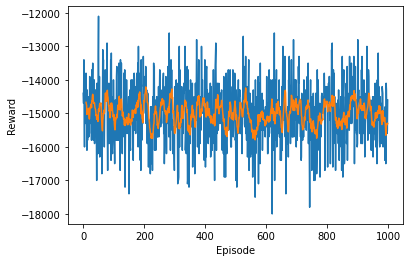

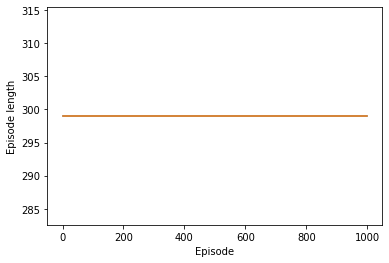

In [ ]:
agent = a2c(env)

Customised PPO Model

In [ ]:
!pip install ppo_torch

In [ ]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

class PPOMemory:
  def __init__(self, batch_size):
    self.states = []
    self.probs = []
    self.vals = []
    self.actions = []
    self.rewards = []
    self.dones = []
    self.batch_size = batch_size

  def generate_batches(self):
    n_states = len(self.states)
    batch_start = np.arange(0, n_states, self.batch_size)
    indices = np.arange(n_states, dtype=np.int64)
    np.random.shuffle(indices)
    batches = [indices[i:i+self.batch_size] for i in batch_start]
    return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

  def store_memory(self, state, action, probs, vals, reward, done):
    self.states.append(state)
    self.actions.append(action)
    self.probs.append(probs)
    self.vals.append(vals)
    self.rewards.append(reward)
    self.dones.append(done)

  def clear_memory(self):
    self.states = []
    self.probs = []
    self.actions = []
    self.rewards = []
    self.dones = []
    self.vals = []

In [ ]:
class ActorNetwork(nn.Module):
  def __init__(self, n_actions, input_dims, alpha, fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/ppo'):
    super(ActorNetwork, self).__init__()
    self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
    self.actor = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
    )
    self.optimizer = optim.Adam(self.parameters(), lr=alpha)
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, state):
    dist = self.actor(state)
    dist = Categorical(dist)  
    return dist

  def save_checkpoint(self):
    T.save(self.state_dict(), self.checkpoint_file)

  def load_checkpoint(self):
    self.load_state_dict(T.load(self.checkpoint_file))

In [ ]:
class CriticNetwork(nn.Module):
  def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/ppo'):
    super(CriticNetwork, self).__init__()
    self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
    self.critic = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
    )
    self.optimizer = optim.Adam(self.parameters(), lr=alpha)
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, state):
    value = self.critic(state)
    return value

  def save_checkpoint(self):
    T.save(self.state_dict(), self.checkpoint_file)

  def load_checkpoint(self):
    self.load_state_dict(T.load(self.checkpoint_file))

In [ ]:
class Agent:
  def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95, policy_clip=0.2, batch_size=64, n_epochs=10):
    self.gamma = gamma
    self.policy_clip = policy_clip
    self.n_epochs = n_epochs
    self.gae_lambda = gae_lambda
    self.actor = ActorNetwork(n_actions, input_dims, alpha)
    self.critic = CriticNetwork(input_dims, alpha)
    self.memory = PPOMemory(batch_size)
       
  def remember(self, state, action, probs, vals, reward, done):
    self.memory.store_memory(state, action, probs, vals, reward, done)

  def save_models(self):
    print('... saving models ...')
    self.actor.save_checkpoint()
    self.critic.save_checkpoint()

  def load_models(self):
    print('... loading models ...')
    self.actor.load_checkpoint()
    self.critic.load_checkpoint()

  def choose_action(self, observation):
    state = T.tensor([observation], dtype=T.float).to(self.actor.device)
    dist = self.actor(state)
    value = self.critic(state)
    action = dist.sample()
    probs = T.squeeze(dist.log_prob(action)).item()
    action = T.squeeze(action).item()
    value = T.squeeze(value).item()
    return action, probs, value

  def learn(self):
    for _ in range(self.n_epochs):
      state_arr, action_arr, old_prob_arr, vals_arr,\
      reward_arr, dones_arr, batches = \
      self.memory.generate_batches()
      values = vals_arr
      advantage = np.zeros(len(reward_arr), dtype=np.float32)
      
      for t in range(len(reward_arr)-1):
        discount = 1
        a_t = 0
        for k in range(t, len(reward_arr)-1):
          a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                          (1-int(dones_arr[k])) - values[k])
          discount *= self.gamma*self.gae_lambda
        advantage[t] = a_t
      advantage = T.tensor(advantage).to(self.actor.device)

      values = T.tensor(values).to(self.actor.device)
      for batch in batches:
        states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
        old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
        actions = T.tensor(action_arr[batch]).to(self.actor.device)
        dist = self.actor(states)
        critic_value = self.critic(states)
        critic_value = T.squeeze(critic_value)
        new_probs = dist.log_prob(actions)
        prob_ratio = new_probs.exp() / old_probs.exp()
        #prob_ratio = (new_probs - old_probs).exp()
        weighted_probs = advantage[batch] * prob_ratio
        weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
        actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()
        returns = advantage[batch] + values[batch]
        critic_loss = (returns-critic_value)**2
        critic_loss = critic_loss.mean()
        total_loss = actor_loss + 0.5*critic_loss
        self.actor.optimizer.zero_grad()
        self.critic.optimizer.zero_grad()
        total_loss.backward()
        self.actor.optimizer.step()
        self.critic.optimizer.step()
        
    self.memory.clear_memory()  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores, figure_file):
  running_avg = np.zeros(len(scores))
  for i in range(len(running_avg)):
    running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
  plt.plot(x, running_avg)
  plt.title('Running average of previous 100 scores')
  plt.savefig(figure_file)

In [ ]:
import gym
import numpy as np
from ppo_torch import Agent
from utils import plot_learning_curve

if __name__ == '__main__':
    env = gym.make('CartPole-v0')
    N = 20
    batch_size = 5
    n_epochs = 4
    alpha = 0.0003
    agent = Agent(n_actions=env.action_space.n, batch_size=batch_size, 
                    alpha=alpha, n_epochs=n_epochs, 
                    input_dims=env.observation_space.shape)
    n_games = 300

    figure_file = 'plots/cartpole.png'

    best_score = env.reward_range[0]
    score_history = []

    learn_iters = 0
    avg_score = 0
    n_steps = 0

    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        while not done:
            action, prob, val = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            n_steps += 1
            score += reward
            agent.remember(observation, action, prob, val, reward, done)
            if n_steps % N == 0:
                agent.learn()
                learn_iters += 1
            observation = observation_
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score:
            best_score = avg_score
            agent.save_models()

        print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
                'time_steps', n_steps, 'learning_steps', learn_iters)
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history, figure_file)

Model Evaluation